***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [11]:
df=pd.read_csv('URL.csv')

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
display(df.head())
print("Shape of our dataset:",df.shape)

,Target,url_char_%,url_char_&,url_char_+,url_char_-,url_char_.,url_char_/,url_char_0,url_char_1,url_char_2,url_char_3,url_char_4,url_char_5,url_char_6,url_char_7,url_char_8,url_char_9,url_char_:,url_char_=,url_char_?,url_char_A,url_char_B,url_char_C,url_char_D,url_char_E,url_char_F,url_char_G,url_char_H,url_char_I,url_char_J,url_char_K,url_char_L,url_char_M,url_char_N,url_char_O,url_char_P,url_char_Q,url_char_R,url_char_S,url_char_T,url_char_U,url_char_V,url_char_W,url_char_X,url_char_Y,url_char_Z,url_char__,url_char_a,url_char_b,url_char_c,url_char_d,url_char_e,url_char_f,url_char_g,url_char_h,url_char_i,url_char_j,url_char_k,url_char_l,url_char_m,url_char_n,url_char_o,url_char_p,url_char_q,url_char_r,url_char_s,url_char_t,url_char_u,url_char_v,url_char_w,url_char_x,url_char_y,url_char_z,url_contains_ip,url_contains_signin,url_contains_www,url_extension_.a,url_extension_.acc,url_extension_.ad,url_extension_.ag,url_extension_.ai,url_extension_.ap,url_extension_.app,url_extension_.asi,url_extension_.au,url_extension_.b,url_extension_.ban,url_extension_.bid,url_extension_.bik,url_extension_.br,url_extension_.c,url_extension_.ca,url_extension_.car,url_extension_.cat,url_extension_.cc,url_extension_.ce,url_extension_.cf,url_extension_.ch,url_extension_.cit,url_extension_.cl,url_extension_.class,url_extension_.cli,url_extension_.com,url_extension_.con,url_extension_.cur,url_extension_.d,url_extension_.dat,url_extension_.de,url_extension_.dec,url_extension_.dis,url_extension_.do,url_extension_.ex,url_extension_.exe,url_extension_.f,url_extension_.fgd,url_extension_.fi,url_extension_.fin,url_extension_.fm,url_extension_.fre,url_extension_.g,url_extension_.gg,url_extension_.gl,url_extension_.gra,url_extension_.h,url_extension_.ha,url_extension_.htm,url_extension_.html,url_extension_.i,url_extension_.icl,url_extension_.id,url_extension_.imp,url_extension_.inf,url_extension_.int,url_extension_.io,url_extension_.it,url_extension_.jpg,url_extension_.l,url_extension_.lid,url_extension_.lif,url_extension_.lin,url_extension_.log,url_extension_.m,url_extension_.man,url_extension_.me,url_extension_.med,url_extension_.mk,url_extension_.mm,url_extension_.mmo,url_extension_.mob,url_extension_.mon,url_extension_.mu,url_extension_.mus,url_extension_.net,url_extension_.new,url_extension_.ng,url_extension_.o,url_extension_.one,url_extension_.org,url_extension_.p,url_extension_.pa,url_extension_.par,url_extension_.ph,url_extension_.php,url_extension_.pip,url_extension_.pit,url_extension_.pk,url_extension_.pl,url_extension_.png,url_extension_.pp,url_extension_.pre,url_extension_.pri,url_extension_.pro,url_extension_.pw,url_extension_.r,url_extension_.ra,url_extension_.res,url_extension_.rev,url_extension_.ri,url_extension_.rs,url_extension_.ru,url_extension_.s,url_extension_.sc,url_extension_.sca,url_extension_.sci,url_extension_.sec,url_extension_.sf,url_extension_.sfl,url_extension_.sh,url_extension_.sha,url_extension_.sit,url_extension_.so,url_extension_.sp,url_extension_.spa,url_extension_.st,url_extension_.sta,url_extension_.sto,url_extension_.str,url_extension_.sup,url_extension_.t,url_extension_.tr,url_extension_.tv,url_extension_.upd,url_extension_.v,url_extension_.ver,url_extension_.vgr,url_extension_.vi,url_extension_.vic,url_extension_.vid,url_extension_.vo,url_extension_.w,url_extension_.web,url_extension_.win,url_extension_.wor,url_extension_.ws,url_extension_.x,url_extension_.xi,url_extension_.xx,url_extension_.xxx,url_extension_.xy,url_extension_.xyz,url_extension_.y,url_extension_.z,url_extension_.zi,url_extension_.zon,url_extension_0,url_extension_0.1,url_extension_0.8,url_extension_endswith_.a,url_extension_endswith_.acc,url_extension_endswith_.ad,url_extension_endswith_.ag,url_extension_endswith_.ai,url_extension_endswith_.ap,url_extension_endswith_.app,url_extension_endswith_.asi,url_extension_endswith_.au,url_extension_endswith_.b,url_extension_endswith_.ban,url_extension_endswith_.bid,url_extension_endswith_.bik,url_extension_ends

Shape of our dataset: (46771, 4194)


#### Let us analyze the balance of classes

In [12]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [13]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
display(np.array(col_no_unique))
### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

print("Shape of our dataset after dropping them:",df.shape)

302 columns have only one unique value in them rendering them meaningless for classification


array(['url_contains_ip', 'url_extension_endswith_.a',
       'url_extension_endswith_.acc', 'url_extension_endswith_.ap',
       'url_extension_endswith_.asi', 'url_extension_endswith_.b',
       'url_extension_endswith_.ban', 'url_extension_endswith_.bik',
       'url_extension_endswith_.c', 'url_extension_endswith_.car',
       'url_extension_endswith_.ce', 'url_extension_endswith_.cit',
       'url_extension_endswith_.cli', 'url_extension_endswith_.con',
       'url_extension_endswith_.cur', 'url_extension_endswith_.d',
       'url_extension_endswith_.dec', 'url_extension_endswith_.dis',
       'url_extension_endswith_.ex', 'url_extension_endswith_.f',
       'url_extension_endswith_.fgd', 'url_extension_endswith_.fin',
       'url_extension_endswith_.fre', 'url_extension_endswith_.g',
       'url_extension_endswith_.gra', 'url_extension_endswith_.h',
       'url_extension_endswith_.ha', 'url_extension_endswith_.i',
       'url_extension_endswith_.icl', 'url_extension_endswith_.imp

Shape of our dataset after dropping them: (46771, 3892)


In [14]:
ext_end=[col for col in df.columns if 'extension_ends' in col]

for col in ext_end:
    df[col]=df[col].astype(int)

# ### Check and converting data types
# df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)
print("Columns which are of type object:",df.dtypes[(df.dtypes=='object')])

Columns which are of type object: url_contains_signin    object
url_contains_www       object
url_host               object
url_ip                 object
dtype: object


#### Next check to see which features have less than 5% varying data

In [15]:
lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)
del lst

print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

3845 columns have more than 95% same values


In [16]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [17]:
columns=col_values[col_values['95_%_same_values']==False].index.values
columns=columns.tolist()
col_values['95_%_same_values'].value_counts()

True     3845
False      46
Name: 95_%_same_values, dtype: int64

In [18]:
print("Columns which are of type object:",df[columns].dtypes[(df.dtypes=='object')])
columns.remove('url_host')

Columns which are of type object: url_host    object
dtype: object


In [19]:
rem=['url_tld_NET','url_tld_COM','url_tld_NE','url_tld_CO','url_extension_endswith_.com', 'url_extension_.c']
for col in rem:
    columns.remove(col)

In [20]:
df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
url_extension_.com,-0.154316,4.061880e-247,-34.113589,9.926271e-241
url_extension_.i,-0.005769,2.122020e-01,-1.243880,2.135748e-01
url_char_m,-0.000765,8.685861e-01,-0.133716,8.936303e-01
url_char_o,0.074650,8.715169e-59,12.338724,1.155801e-34
url_char_j,0.116675,1.984745e-141,16.725416,1.082992e-61
url_char_v,0.105337,1.682865e-115,17.027650,6.949488e-64
url_char_c,0.110988,4.385017e-128,17.136575,1.205077e-64
url_char_g,0.119543,2.045127e-148,20.120991,6.796065e-88
url_char_-,0.188291,0.000000e+00,22.532080,1.071961e-108



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,
url_extension_.net,138.8931,0.0,0.0545


In [21]:
print("Features we will be using:")
columns.remove('Target')
display(columns)

Features we will be using:


['url_char_-',
 'url_char_.',
 'url_char_a',
 'url_char_b',
 'url_char_c',
 'url_char_d',
 'url_char_e',
 'url_char_f',
 'url_char_g',
 'url_char_h',
 'url_char_i',
 'url_char_j',
 'url_char_k',
 'url_char_l',
 'url_char_m',
 'url_char_n',
 'url_char_o',
 'url_char_p',
 'url_char_r',
 'url_char_s',
 'url_char_t',
 'url_char_u',
 'url_char_v',
 'url_char_w',
 'url_char_x',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extension_.i',
 'url_extension_.net',
 'url_extensions',
 'url_length',
 'url_tlds',
 'url_words_with_length_4',
 'url_words_with_length_5',
 'url_words_with_length_6',
 'url_words_with_length_7',
 'url_words_with_length_8']

In [22]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [23]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [24]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.963892452427
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31816    77    31893
True        1274  4249     5523
__all__    33090  4326    37416

Accuracy of the KNN model for twst data is: 0.952966328167
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7958    26     7984
True         414   957     1371
__all__     8372   983     9355



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.951464614069
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31467   426    31893
True        1390  4133     5523
__all__    32857  4559    37416

Accuracy of the Logistic Regression model for twst data is: 0.949438802779
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7883   101     7984
True         372   999     1371
__all__     8255  1100     9355



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.994627966645
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31885     8    31893
True         193  5330     5523
__all__    32078  5338    37416

Accuracy of the Random Forest Classifier for twst data is: 0.959700694816
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7920    64     7984
True         313  1058     1371
__all__     8233  1122     9355



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.946840923669
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31417   476    31893
True        1513  4010     5523
__all__    32930  4486    37416

Accuracy of the Ada Boost Classifier for twst data is: 0.943666488509
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7861   123     7984
True         404   967     1371
__all__     8265  1090     9355



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.960017104982
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31548   345    31893
True        1151  4372     5523
__all__    32699  4717    37416

Accuracy of the Gradient Boosting Classifier for twst data is: 0.954142169963
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7890    94     7984
True         335  1036     1371
__all__     8225  1130     9355



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.999973273466
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31893     0    31893
True           1  5522     5523
__all__    31894  5522    37416

Accuracy of the Extra Tree Classifier for twst data is: 0.960448957777
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7946    38     7984
True         332  1039     1371
__all__     8278  1077     9355



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.994975411589
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31884     9    31893
True         179  5344     5523
__all__    32063  5353    37416

Accuracy of the Bagging model for twst data is: 0.959700694816
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7914    70     7984
True         307  1064     1371
__all__     8221  1134     9355



Neural Network-1
The accuracy of the model on training data is: 0.997701518067


Predicted  False  True  __all__
Actual                         
False      31887     6    31893
True          80  5443     5523
__all__    31967  5449    37416

The accuracy of the model on test data is: 0.953821485836


Predicted  False  True  __all__
Actual                         
False       7838   146     7984
True         286  1085     1371
__all__     8124  1231     9355

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [25]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [26]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.963892,4249.0,31816.0,77.0,1274.0,0.002414,0.230672
LogisticRegression,0.951465,4133.0,31467.0,426.0,1390.0,0.013357,0.251675
RandomForestClassifier,0.994628,5330.0,31885.0,8.0,193.0,0.000251,0.034945
AdaBoostClassifier,0.946841,4010.0,31417.0,476.0,1513.0,0.014925,0.273945
GradientBoostingClassifier,0.960017,4372.0,31548.0,345.0,1151.0,0.010817,0.208401
ExtraTreeClassifier,0.999973,5522.0,31893.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.994975,5344.0,31884.0,9.0,179.0,0.000282,0.032410
Neural Network-1,0.997702,5443.0,31887.0,6.0,80.0,0.000188,0.014485


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.952966,957.0,7958.0,26.0,414.0,0.003257,0.301969,0.847387
LogisticRegression,0.949439,999.0,7883.0,101.0,372.0,0.012650,0.271335,0.858007
RandomForestClassifier,0.959701,1058.0,7920.0,64.0,313.0,0.008016,0.228301,0.881842
AdaBoostClassifier,0.943666,967.0,7861.0,123.0,404.0,0.015406,0.294675,0.844959
GradientBoostingClassifier,0.954142,1036.0,7890.0,94.0,335.0,0.011774,0.244347,0.871940
ExtraTreeClassifier,0.960449,1039.0,7946.0,38.0,332.0,0.004760,0.242159,0.876541
BaggingClassifier,0.959701,1064.0,7914.0,70.0,307.0,0.008768,0.223924,0.883654
Neural Network-1,0.953821,1085.0,7838.0,146.0,286.0,0.018287,0.208607,0.883654


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [27]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [30]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [31]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 46771, Columns: 39]
  Relationships:
    No relationships

In [32]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 2850 features
EntitySet scattered to workers in 7.450 seconds
Elapsed: 00:31 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [33]:
feature_matrix_sessions.head()

,url_char_-,url_char_.,url_char_a,url_char_b,url_char_c,url_char_d,url_char_e,url_char_f,url_char_g,url_char_h,url_char_i,url_char_j,url_char_k,url_char_l,url_char_m,url_char_n,url_char_o,url_char_p,url_char_r,url_char_s,url_char_t,url_char_u,url_char_v,url_char_w,url_char_x,url_char_y,url_char_z,url_extension_.com,url_extension_.i,url_extension_.net,url_extensions,url_length,url_tlds,url_words_with_length_4,url_words_with_length_5,url_words_with_length_6,url_words_with_length_7,url_words_with_length_8,url_char_k + url_char_y,url_char_g + url_extension_.net,url_char_v + url_char_y,url_char_- + url_words_with_length_4,url_char_f + url_char_y,url_char_e + url_char_j,url_char_i + url_char_l,url_char_k + url_char_u,url_char_g + url_char_h,url_char_x + url_extension_.com,url_char_a + url_char_x,url_char_z + url_extensions,url_char_w + url_words_with_length_7,url_char_e + url_char_z,url_char_i + url_extension_.com,url_char_e + url_char_r,url_char_d + url_char_m,url_extensions + url_length,url_char_p + url_char_z,url_char_r + url_words_with_length_4,url_char_l + url_char_m,url_char_b + url_char_r,url_extension_.i + url_words_with_length_8,url_char_- + url_char_g,url_char_n + url_words_with_length_6,url_char_c + url_char_o,url_char_s + url_words_with_length_7,url_char_d + url_char_l,url_char_o + url_extension_.net,url_char_. + url_char_o,url_char_t + url_words_with_length_6,url_char_r + url_words_with_length_5,url_char_w + url_words_with_length_6,url_char_b + url_tlds,url_char_n + url_char_s,url_char_c + url_extensions,url_char_b + url_char_y,url_char_u + url_words_with_length_6,url_char_w + url_tlds,url_char_p + url_char_x,url_char_k + url_extensions,url_char_c + url_char_t,url_char_k + url_char_s,url_extension_.com + url_tlds,url_char_b + url_char_l,url_words_with_length_4 + url_words_with_length_5,url_char_. + url_char_u,url_char_t + url_words_with_length_8,url_char_h + url_char_x,url_char_o + url_char_r,url_char_d + url_words_with_length_8,url_char_b + url_char_u,url_char_s + url_char_u,url_char_f + url_char_p,url_words_with_length_5 + url_words_with_length_8,url_char_z + url_extension_.com,url_char_- + url_words_with_length_6,url_char_f + url_char_j,url_char_e + url_char_y,url_extension_.i + url_length,url_char_h + url_words_with_length_8,url_char_j + url_char_t,url_char_. + url_char_h,url_char_i + url_char_p,url_char_f + url_char_u,url_char_n + url_char_t,url_char_- + url_words_with_length_7,url_extension_.com + url_extension_.i,url_char_s + url_char_y,url_char_g + url_extensions,url_char_u + url_extension_.net,url_char_. + url_words_with_length_4,url_char_f + url_length,url_char_a + url_words_with_length_8,url_char_f + url_char_w,url_words_with_length_4 + url_words_with_length_8,url_char_- + url_char_r,url_char_n + url_extensions,url_char_- + url_char_d,url_char_j + url_char_v,url_char_i + url_char_u,url_char_- + url_char_f,url_char_h + url_char_k,url_char_l + url_char_s,url_char_s + url_words_with_length_4,url_char_v + url_words_with_length_4,url_char_t + url_extensions,url_char_f + url_extension_.com,url_char_f + url_char_n,url_char_u + url_char_x,url_char_k + url_words_with_length_7,url_char_m + url_extension_.i,url_char_i + url_char_v,url_char_k + url_char_x,url_char_. + url_char_k,url_char_l + url_words_with_length_6,url_char_i + url_char_z,url_char_v + url_words_with_length_5,url_char_e + url_char_s,url_char_o + url_tlds,url_char_f + url_words_with_length_5,url_char_m + url_char_o,url_char_g + url_words_with_length_4,url_char_. + url_char_w,url_char_- + url_extension_.net,url_char_w + url_length,url_char_z + url_length,url_char_f + url_words_with_length_4,url_extension_.i + url_extensions,url_char_- + url_extension_.i,url_char_- + url_char_u,url_char_e + url_length,url_char_r + url_char_v,url_char_a + url_char_m,url_char_a + url_char_l,url_char_k + url_char_z,url_length + url_words_with_length_8,url_char_b + url_char_n,url_char_h + url_char_t,url_char_. + url_words_with_length_7,url_char_b + url_char_g,url_char_r + url_ch

In [34]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [35]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [36]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [37]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [38]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [39]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [40]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [41]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(46771, 36)

In [42]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['url_char_. + url_char_w',
 'url_length + url_words_with_length_6',
 'url_length + url_words_with_length_5',
 'url_length + url_tlds',
 'url_length',
 'url_extensions + url_length',
 'url_extension_.com + url_length',
 'url_char_y + url_length',
 'url_char_w + url_words_with_length_8',
 'url_char_w + url_length',
 'url_char_w + url_extensions',
 'url_char_w + url_char_y',
 'url_char_w * url_extensions',
 'url_char_p + url_length',
 'url_char_m + url_length',
 'url_char_l + url_length',
 'url_char_i + url_char_w',
 'url_char_h + url_length',
 'url_char_h + url_extensions',
 'url_char_g + url_length',
 'url_char_f + url_length',
 'url_char_e + url_length',
 'url_char_c + url_length',
 'url_char_b + url_length',
 'url_char_a + url_length',
 'url_char_. + url_length',
 'url_char_. + url_extension_.net',
 'url_char_. + url_extension_.i',
 'url_char_. + url_char_z',
 'url_char_. + url_char_y',
 'url_char_. + url_char_j',
 'url_char_. + url_char_h',
 'url_char_. * url_char_w',
 'url_char_.',

In [43]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [44]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.958974770152
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31494   396    31890
True        1139  4387     5526
__all__    32633  4783    37416

Accuracy of the KNN model for twst data is: 0.952538749332
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7856   131     7987
True         313  1055     1368
__all__     8169  1186     9355



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.941549069917
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31414   476    31890
True        1711  3815     5526
__all__    33125  4291    37416

Accuracy of the Logistic Regression model for twst data is: 0.945804382683
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7873   114     7987
True         393   975     1368
__all__     8266  1089     9355



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.993612358349
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31867    23    31890
True         216  5310     5526
__all__    32083  5333    37416

Accuracy of the Random Forest Classifier for twst data is: 0.956493853554
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7883   104     7987
True         303  1065     1368
__all__     8186  1169     9355



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.936337395767
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31314   576    31890
True        1806  3720     5526
__all__    33120  4296    37416

Accuracy of the Ada Boost Classifier for twst data is: 0.935970069482
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7840   147     7987
True         452   916     1368
__all__     8292  1063     9355



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.948578148386
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31380   510    31890
True        1414  4112     5526
__all__    32794  4622    37416

Accuracy of the Gradient Boosting Classifier for twst data is: 0.948690539818
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7854   133     7987
True         347  1021     1368
__all__     8201  1154     9355



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.998850759034
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31890     0    31890
True          43  5483     5526
__all__    31933  5483    37416

Accuracy of the Extra Tree Classifier for twst data is: 0.955104222341
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7870   117     7987
True         303  1065     1368
__all__     8173  1182     9355



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.993104554201
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31851    39    31890
True         219  5307     5526
__all__    32070  5346    37416

Accuracy of the Bagging model for twst data is: 0.954462854089
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7845   142     7987
True         284  1084     1368
__all__     8129  1226     9355



Neural Network-1
The accuracy of the model on training data is: 0.970654265555


Predicted  False  True  __all__
Actual                         
False      31612   278    31890
True         820  4706     5526
__all__    32432  4984    37416

The accuracy of the model on test data is: 0.960769641903


Predicted  False  True  __all__
Actual                         
False       7865   122     7987
True         245  1123     1368
__all__     8110  1245     9355

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [45]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [46]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.958975,4387.0,31494.0,396.0,1139.0,0.012418,0.206117
LogisticRegression,0.941549,3815.0,31414.0,476.0,1711.0,0.014926,0.309627
RandomForestClassifier,0.993612,5310.0,31867.0,23.0,216.0,0.000721,0.039088
AdaBoostClassifier,0.936337,3720.0,31314.0,576.0,1806.0,0.018062,0.326819
GradientBoostingClassifier,0.948578,4112.0,31380.0,510.0,1414.0,0.015992,0.255881
ExtraTreeClassifier,0.998851,5483.0,31890.0,0.0,43.0,0.000000,0.007781
BaggingClassifier,0.993105,5307.0,31851.0,39.0,219.0,0.001223,0.039631
Neural Network-1,0.970654,4706.0,31612.0,278.0,820.0,0.008717,0.148389


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.952539,1055.0,7856.0,131.0,313.0,0.016402,0.228801,0.877399
LogisticRegression,0.945804,975.0,7873.0,114.0,393.0,0.014273,0.287281,0.849223
RandomForestClassifier,0.956494,1065.0,7883.0,104.0,303.0,0.013021,0.221491,0.882744
AdaBoostClassifier,0.935970,916.0,7840.0,147.0,452.0,0.018405,0.330409,0.825593
GradientBoostingClassifier,0.948691,1021.0,7854.0,133.0,347.0,0.016652,0.253655,0.864846
ExtraTreeClassifier,0.955104,1065.0,7870.0,117.0,303.0,0.014649,0.221491,0.881930
BaggingClassifier,0.954463,1084.0,7845.0,142.0,284.0,0.017779,0.207602,0.887309
Neural Network-1,0.960770,1123.0,7865.0,122.0,245.0,0.015275,0.179094,0.887309


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [47]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [48]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

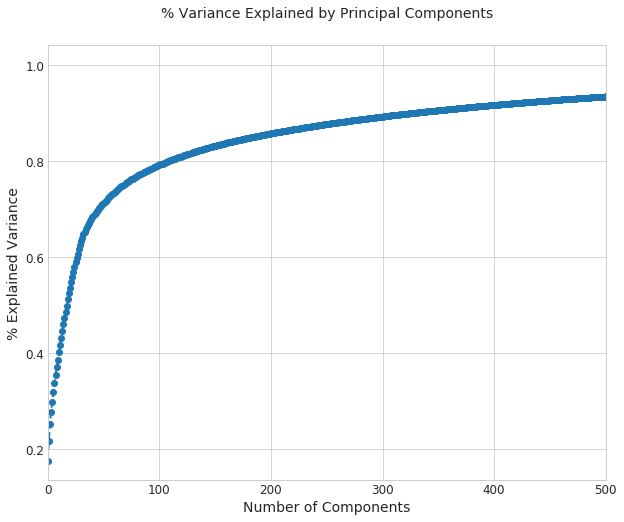

In [49]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,500])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [50]:
np.where(np.cumsum(pca.explained_variance_ratio_)>=0.95)[0]

array([ 613,  614,  615, ..., 2847, 2848, 2849])

In [51]:
pca=PCA(n_components=613,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 613 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 613 components is: 0.949031271907


In [52]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [56]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [57]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,613).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.920542014112
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31841    49    31890
True        2924  2602     5526
__all__    34765  2651    37416

Accuracy of the KNN model for twst data is: 0.902618920363
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7972    15     7987
True         896   472     1368
__all__     8868   487     9355



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.963838999359
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31591   299    31890
True        1054  4472     5526
__all__    32645  4771    37416

Accuracy of the Logistic Regression model for twst data is: 0.962159273116
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7903    84     7987
True         270  1098     1368
__all__     8173  1182     9355



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.993318366474
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31886     4    31890
True         246  5280     5526
__all__    32132  5284    37416

Accuracy of the Random Forest Classifier for twst data is: 0.927632282202
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7862   125     7987
True         552   816     1368
__all__     8414   941     9355



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.937192644858
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31234   656    31890
True        1694  3832     5526
__all__    32928  4488    37416

Accuracy of the Ada Boost Classifier for twst data is: 0.935221806521
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7810   177     7987
True         429   939     1368
__all__     8239  1116     9355



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.954778704298
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31625   265    31890
True        1427  4099     5526
__all__    33052  4364    37416

Accuracy of the Gradient Boosting Classifier for twst data is: 0.950080171032
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7903    84     7987
True         383   985     1368
__all__     8286  1069     9355



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.999973273466
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31890     0    31890
True           1  5525     5526
__all__    31891  5525    37416

Accuracy of the Extra Tree Classifier for twst data is: 0.908177445216
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7887   100     7987
True         759   609     1368
__all__     8646   709     9355



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.993986529827
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31884     6    31890
True         219  5307     5526
__all__    32103  5313    37416

Accuracy of the Bagging model for twst data is: 0.941849278461
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7864   123     7987
True         421   947     1368
__all__     8285  1070     9355



Neural Network-1
The accuracy of the model on training data is: 0.999224930511


Predicted  False  True  __all__
Actual                         
False      31871    19    31890
True          10  5516     5526
__all__    31881  5535    37416

The accuracy of the model on test data is: 0.953287012293


Predicted  False  True  __all__
Actual                         
False       7801   186     7987
True         251  1117     1368
__all__     8052  1303     9355

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [58]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [59]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.920542,2602.0,31841.0,49.0,2924.0,0.001537,0.529135
LogisticRegression,0.963839,4472.0,31591.0,299.0,1054.0,0.009376,0.190735
RandomForestClassifier,0.993318,5280.0,31886.0,4.0,246.0,0.000125,0.044517
AdaBoostClassifier,0.937193,3832.0,31234.0,656.0,1694.0,0.020571,0.306551
GradientBoostingClassifier,0.954779,4099.0,31625.0,265.0,1427.0,0.008310,0.258234
ExtraTreeClassifier,0.999973,5525.0,31890.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.993987,5307.0,31884.0,6.0,219.0,0.000188,0.039631
Neural Network-1,0.999225,5516.0,31871.0,19.0,10.0,0.000596,0.001810


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.902619,472.0,7972.0,15.0,896.0,0.001878,0.654971,0.671576
LogisticRegression,0.962159,1098.0,7903.0,84.0,270.0,0.010517,0.197368,0.896057
RandomForestClassifier,0.927632,816.0,7862.0,125.0,552.0,0.015650,0.403509,0.790420
AdaBoostClassifier,0.935222,939.0,7810.0,177.0,429.0,0.022161,0.313596,0.832121
GradientBoostingClassifier,0.950080,985.0,7903.0,84.0,383.0,0.010517,0.279971,0.854756
ExtraTreeClassifier,0.908177,609.0,7887.0,100.0,759.0,0.012520,0.554825,0.716328
BaggingClassifier,0.941849,947.0,7864.0,123.0,421.0,0.015400,0.307749,0.838426
Neural Network-1,0.953287,1117.0,7801.0,186.0,251.0,0.023288,0.183480,0.838426


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [60]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,613).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [62]:
print('Features we will be using:\n')
columns=list(columns)
columns.remove('domain')
display(columns)

Features we will be using:



['url_char_-',
 'url_char_.',
 'url_char_a',
 'url_char_b',
 'url_char_c',
 'url_char_d',
 'url_char_e',
 'url_char_f',
 'url_char_g',
 'url_char_h',
 'url_char_i',
 'url_char_j',
 'url_char_k',
 'url_char_l',
 'url_char_m',
 'url_char_n',
 'url_char_o',
 'url_char_p',
 'url_char_r',
 'url_char_s',
 'url_char_t',
 'url_char_u',
 'url_char_v',
 'url_char_w',
 'url_char_x',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extension_.i',
 'url_extension_.net',
 'url_extensions',
 'url_length',
 'url_tlds',
 'url_words_with_length_4',
 'url_words_with_length_5',
 'url_words_with_length_6',
 'url_words_with_length_7',
 'url_words_with_length_8']

In [63]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [64]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [65]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.977753739065
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30505   1388    31893
True          31  31862    31893
__all__    30536  33250    63786

Accuracy of the KNN model for twst data is: 0.918225547835
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7459   525     7984
True         240  1131     1371
__all__     7699  1656     9355



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.90008779356
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29614   2279    31893
True        4094  27799    31893
__all__    33708  30078    63786

Accuracy of the Logistic Regression model for twst data is: 0.915232495991
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7407   577     7984
True         216  1155     1371
__all__     7623  1732     9355



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.998353870755
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31888      5    31893
True         100  31793    31893
__all__    31988  31798    63786

Accuracy of the Random Forest Classifier for twst data is: 0.958311063602
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7897    87     7984
True         303  1068     1371
__all__     8200  1155     9355



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.937462766124
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30397   1496    31893
True        2493  29400    31893
__all__    32890  30896    63786

Accuracy of the Ada Boost Classifier for twst data is: 0.930197755211
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7621   363     7984
True         290  1081     1371
__all__     7911  1444     9355



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.965415608441
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31063    830    31893
True        1376  30517    31893
__all__    32439  31347    63786

Accuracy of the Gradient Boosting Classifier for twst data is: 0.948369855692
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7780   204     7984
True         279  1092     1371
__all__     8059  1296     9355



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.999984322579
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31893      0    31893
True           1  31892    31893
__all__    31894  31892    63786

Accuracy of the Extra Tree Classifier for twst data is: 0.958311063602
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7902    82     7984
True         308  1063     1371
__all__     8210  1145     9355



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.997522967422
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31886      7    31893
True         151  31742    31893
__all__    32037  31749    63786

Accuracy of the Bagging model for twst data is: 0.958845537146
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7895    89     7984
True         296  1075     1371
__all__     8191  1164     9355



Neural Network-1
The accuracy of the model on training data is: 0.997585677108


Predicted  False   True  __all__
Actual                          
False      31809     84    31893
True          70  31823    31893
__all__    31879  31907    63786

The accuracy of the model on test data is: 0.944628540887


Predicted  False  True  __all__
Actual                         
False       7737   247     7984
True         271  1100     1371
__all__     8008  1347     9355

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [66]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [67]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.977754,31862.0,30505.0,1388.0,31.0,0.043521,0.000972
LogisticRegression,0.900088,27799.0,29614.0,2279.0,4094.0,0.071458,0.128367
RandomForestClassifier,0.998354,31793.0,31888.0,5.0,100.0,0.000157,0.003135
AdaBoostClassifier,0.937463,29400.0,30397.0,1496.0,2493.0,0.046907,0.078168
GradientBoostingClassifier,0.965416,30517.0,31063.0,830.0,1376.0,0.026025,0.043144
ExtraTreeClassifier,0.999984,31892.0,31893.0,0.0,1.0,0.000000,0.000031
BaggingClassifier,0.997523,31742.0,31886.0,7.0,151.0,0.000219,0.004735
Neural Network-1,0.997586,31823.0,31809.0,84.0,70.0,0.002634,0.002195


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.918226,1131.0,7459.0,525.0,240.0,0.065757,0.175055,0.879594
LogisticRegression,0.915232,1155.0,7407.0,577.0,216.0,0.072270,0.157549,0.885091
RandomForestClassifier,0.958311,1068.0,7897.0,87.0,303.0,0.010897,0.221007,0.884048
AdaBoostClassifier,0.930198,1081.0,7621.0,363.0,290.0,0.045466,0.211524,0.871505
GradientBoostingClassifier,0.948370,1092.0,7780.0,204.0,279.0,0.025551,0.203501,0.885474
ExtraTreeClassifier,0.958311,1063.0,7902.0,82.0,308.0,0.010271,0.224654,0.882538
BaggingClassifier,0.958846,1075.0,7895.0,89.0,296.0,0.011147,0.215901,0.886476
Neural Network-1,0.944629,1100.0,7737.0,247.0,271.0,0.030937,0.197666,0.886476


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [68]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [69]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (13788, 3893)


,index,Target,url_char_%,url_char_&,url_char_+,url_char_-,url_char_.,url_char_/,url_char_0,url_char_1,url_char_2,url_char_3,url_char_4,url_char_5,url_char_6,url_char_7,url_char_8,url_char_9,url_char_:,url_char_=,url_char_?,url_char_A,url_char_B,url_char_C,url_char_D,url_char_E,url_char_F,url_char_G,url_char_H,url_char_I,url_char_J,url_char_K,url_char_L,url_char_M,url_char_N,url_char_O,url_char_P,url_char_Q,url_char_R,url_char_S,url_char_T,url_char_U,url_char_V,url_char_W,url_char_X,url_char_Y,url_char_Z,url_char__,url_char_a,url_char_b,url_char_c,url_char_d,url_char_e,url_char_f,url_char_g,url_char_h,url_char_i,url_char_j,url_char_k,url_char_l,url_char_m,url_char_n,url_char_o,url_char_p,url_char_q,url_char_r,url_char_s,url_char_t,url_char_u,url_char_v,url_char_w,url_char_x,url_char_y,url_char_z,url_contains_signin,url_contains_www,url_extension_.a,url_extension_.acc,url_extension_.ad,url_extension_.ag,url_extension_.ai,url_extension_.ap,url_extension_.app,url_extension_.asi,url_extension_.au,url_extension_.b,url_extension_.ban,url_extension_.bid,url_extension_.bik,url_extension_.br,url_extension_.c,url_extension_.ca,url_extension_.car,url_extension_.cat,url_extension_.cc,url_extension_.ce,url_extension_.cf,url_extension_.ch,url_extension_.cit,url_extension_.cl,url_extension_.class,url_extension_.cli,url_extension_.com,url_extension_.con,url_extension_.cur,url_extension_.d,url_extension_.dat,url_extension_.de,url_extension_.dec,url_extension_.dis,url_extension_.do,url_extension_.ex,url_extension_.exe,url_extension_.f,url_extension_.fgd,url_extension_.fi,url_extension_.fin,url_extension_.fm,url_extension_.fre,url_extension_.g,url_extension_.gg,url_extension_.gl,url_extension_.gra,url_extension_.h,url_extension_.ha,url_extension_.htm,url_extension_.html,url_extension_.i,url_extension_.icl,url_extension_.id,url_extension_.imp,url_extension_.inf,url_extension_.int,url_extension_.io,url_extension_.it,url_extension_.jpg,url_extension_.l,url_extension_.lid,url_extension_.lif,url_extension_.lin,url_extension_.log,url_extension_.m,url_extension_.man,url_extension_.me,url_extension_.med,url_extension_.mk,url_extension_.mm,url_extension_.mmo,url_extension_.mob,url_extension_.mon,url_extension_.mu,url_extension_.mus,url_extension_.net,url_extension_.new,url_extension_.ng,url_extension_.o,url_extension_.one,url_extension_.org,url_extension_.p,url_extension_.pa,url_extension_.par,url_extension_.ph,url_extension_.php,url_extension_.pip,url_extension_.pit,url_extension_.pk,url_extension_.pl,url_extension_.png,url_extension_.pp,url_extension_.pre,url_extension_.pri,url_extension_.pro,url_extension_.pw,url_extension_.r,url_extension_.ra,url_extension_.res,url_extension_.rev,url_extension_.ri,url_extension_.rs,url_extension_.ru,url_extension_.s,url_extension_.sc,url_extension_.sca,url_extension_.sci,url_extension_.sec,url_extension_.sf,url_extension_.sfl,url_extension_.sh,url_extension_.sha,url_extension_.sit,url_extension_.so,url_extension_.sp,url_extension_.spa,url_extension_.st,url_extension_.sta,url_extension_.sto,url_extension_.str,url_extension_.sup,url_extension_.t,url_extension_.tr,url_extension_.tv,url_extension_.upd,url_extension_.v,url_extension_.ver,url_extension_.vgr,url_extension_.vi,url_extension_.vic,url_extension_.vid,url_extension_.vo,url_extension_.w,url_extension_.web,url_extension_.win,url_extension_.wor,url_extension_.ws,url_extension_.x,url_extension_.xi,url_extension_.xx,url_extension_.xxx,url_extension_.xy,url_extension_.xyz,url_extension_.y,url_extension_.z,url_extension_.zi,url_extension_.zon,url_extension_0,url_extension_0.1,url_extension_0.8,url_extension_endswith_.ad,url_extension_endswith_.ag,url_extension_endswith_.ai,url_extension_endswith_.app,url_extension_endswith_.au,url_extension_endswith_.bid,url_extension_endswith_.br,url_extension_endswith_.ca,url_extension_endswith_.cat,url_extension_endswith_.cc,url_extension_endswith_.cf,url_extension_endswith_.ch,url_extension_endswith_.cl,url_extension_endswith_.class

In [70]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [71]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [72]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



['url_char_-',
 'url_char_.',
 'url_char_a',
 'url_char_b',
 'url_char_c',
 'url_char_d',
 'url_char_e',
 'url_char_f',
 'url_char_g',
 'url_char_h',
 'url_char_i',
 'url_char_j',
 'url_char_k',
 'url_char_l',
 'url_char_m',
 'url_char_n',
 'url_char_o',
 'url_char_p',
 'url_char_r',
 'url_char_s',
 'url_char_t',
 'url_char_u',
 'url_char_v',
 'url_char_w',
 'url_char_x',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extension_.i',
 'url_extension_.net',
 'url_extensions',
 'url_length',
 'url_tlds',
 'url_words_with_length_4',
 'url_words_with_length_5',
 'url_words_with_length_6',
 'url_words_with_length_7',
 'url_words_with_length_8']

In [73]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.912783318223
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5419   114     5533
True         848  4649     5497
__all__     6267  4763    11030

Accuracy of the KNN model for twst data is: 0.891588107324
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1325    36     1361
True         263  1134     1397
__all__     1588  1170     2758



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.89936536718
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5145   388     5533
True         722  4775     5497
__all__     5867  5163    11030

Accuracy of the Logistic Regression model for twst data is: 0.893401015228
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1262    99     1361
True         195  1202     1397
__all__     1457  1301     2758



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.991296464189
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5532     1     5533
True          95  5402     5497
__all__     5627  5403    11030

Accuracy of the Random Forest Classifier for twst data is: 0.908266860044
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1303    58     1361
True         195  1202     1397
__all__     1498  1260     2758



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.895466908432
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5090   443     5533
True         710  4787     5497
__all__     5800  5230    11030

Accuracy of the Ada Boost Classifier for twst data is: 0.891588107324
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1243   118     1361
True         181  1216     1397
__all__     1424  1334     2758



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.908975521306
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5246   287     5533
True         717  4780     5497
__all__     5963  5067    11030

Accuracy of the Gradient Boosting Classifier for twst data is: 0.898839738941
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1276    85     1361
True         194  1203     1397
__all__     1470  1288     2758



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 1.0
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5533     0     5533
True           0  5497     5497
__all__     5533  5497    11030

Accuracy of the Extra Tree Classifier for twst data is: 0.902828136331
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1285    76     1361
True         192  1205     1397
__all__     1477  1281     2758



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.98939256573
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5518    15     5533
True         102  5395     5497
__all__     5620  5410    11030

Accuracy of the Bagging model for twst data is: 0.902102973169
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1291    70     1361
True         200  1197     1397
__all__     1491  1267     2758



Neural Network-1
The accuracy of the model on training data is: 0.993291024446


Predicted  False  True  __all__
Actual                         
False       5521    12     5533
True          62  5435     5497
__all__     5583  5447    11030

The accuracy of the model on test data is: 0.886511965192


Predicted  False  True  __all__
Actual                         
False       1229   132     1361
True         181  1216     1397
__all__     1410  1348     2758

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [74]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [75]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.912783,4649.0,5419.0,114.0,848.0,0.020604,0.154266
LogisticRegression,0.899365,4775.0,5145.0,388.0,722.0,0.070125,0.131344
RandomForestClassifier,0.991296,5402.0,5532.0,1.0,95.0,0.000181,0.017282
AdaBoostClassifier,0.895467,4787.0,5090.0,443.0,710.0,0.080065,0.129161
GradientBoostingClassifier,0.908976,4780.0,5246.0,287.0,717.0,0.051871,0.130435
ExtraTreeClassifier,1.000000,5497.0,5533.0,0.0,0.0,0.000000,0.000000
BaggingClassifier,0.989393,5395.0,5518.0,15.0,102.0,0.002711,0.018556
Neural Network-1,0.993291,5435.0,5521.0,12.0,62.0,0.002169,0.011279


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.891588,1134.0,1325.0,36.0,263.0,0.026451,0.188261,0.892644
LogisticRegression,0.893401,1202.0,1262.0,99.0,195.0,0.072741,0.139585,0.893837
RandomForestClassifier,0.908267,1202.0,1303.0,58.0,195.0,0.042616,0.139585,0.908900
AdaBoostClassifier,0.891588,1216.0,1243.0,118.0,181.0,0.086701,0.129563,0.891868
GradientBoostingClassifier,0.898840,1203.0,1276.0,85.0,194.0,0.062454,0.138869,0.899338
ExtraTreeClassifier,0.902828,1205.0,1285.0,76.0,192.0,0.055841,0.137437,0.903361
BaggingClassifier,0.902103,1197.0,1291.0,70.0,200.0,0.051433,0.143164,0.902702
Neural Network-1,0.886512,1216.0,1229.0,132.0,181.0,0.096988,0.129563,0.902702


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [76]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [77]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')